# Modelado de los datos

En este notebook se entrenan diferentes modelos en base a los datos limpios de peajes de la Ciudad de Buenos Aires. El objetivo de estos modelos es predecir la cantidad de pasos por hora que habría en cada peaje, partiendo de las características esperadas del “paso” (la fecha de paso, el sentido de viaje, el tipo de vehículo y la forma en la que abonarán el peaje, por ejemplo). 

## Setup de librerías

Se importan las librerías necesarias

In [2]:
# Librerías estándar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Preprocesamiento y división de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Modelos de aprendizaje automático
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Métricas de evaluación
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
# Codificación de variables categóricas
import category_encoders as ce

from itertools import product
from datetime import datetime

## Funciones útiles

A continuación se definen funciones útiles de preprocesamiento y graficación de los datos.

In [3]:
def prepare_dataset(filepath):
    """
    Carga y preprocesa el dataset de peajes.
    """

    dataset = pd.read_csv(filepath)

    # Se eliminan las filas que contienen "Otros" en la columna "tipo_cobro"
    # Se toma esta decisión porque su impacto es mínimo
    dataset = dataset[dataset["tipo_cobro"] != "Otros"]

    # Se separa el día y el mes del año en columnas separadas
    # Necesitamos que las variables sean numéricas
    dataset["nro_dia"] = pd.to_datetime(dataset["fecha"]).dt.day
    dataset["nro_mes"] = pd.to_datetime(dataset["fecha"]).dt.month
    dataset["anio"] = pd.to_datetime(dataset["fecha"]).dt.year
    dataset.drop("fecha", axis=1, inplace=True)

    return dataset

In [ ]:
def encode_columns(dataset):
    """
    Codifica las columnas del dataset que tienen variables cualitativas.
    """

    dataset = dataset.copy()

    # Se codifica la categoría día de la semana con label encoding (codificación de etiquetas)
    # Se toma esta decisión porque la variable es ordinal
    day_encoding = {
        'Lunes': 0,
        'Martes': 1,
        'Miercoles': 2,
        'Jueves': 3,
        'Viernes': 4,
        'Sabado': 5,
        'Domingo': 6
    }

    dataset['dia_semana'] = dataset['dia'].map(day_encoding)
    dataset.drop("dia", axis=1, inplace=True)

    # Se codifica el resto de las variables categóricas con binary encoding (codificación binaria)
    binary_encoder = ce.BinaryEncoder(cols=["id_peaje", "sentido", "tipo_vehiculo", "tipo_cobro"])
    dataset = binary_encoder.fit_transform(dataset)
    # Eliminamos las columnas sentido_1 y tipo_vehiculo_1 porque no aportan información
    dataset.drop(["sentido_1", "tipo_vehiculo_1"], axis=1, inplace=True)

    # Cambiarle el nombre a las columnas sentido y tipo_vehículo para saber qué significa cada valor
    dataset.rename(columns={'sentido_0': 'hacia_provincia'}, inplace=True)
    dataset.rename(columns={'tipo_vehiculo_0': 'es_pesado'}, inplace=True)

    return dataset

In [5]:
def get_test_train_data(*x_columns, test_size=0.3, dataset=None):
    """
    Divide el dataset en variables de entrada y salida, y en entrenamiento y prueba.
    """
    if "all" in x_columns:
        x_columns = ['hora', 
                     'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 
                     'hacia_provincia', 'es_pesado', 
                     'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3', 
                     'nro_dia', 'nro_mes', 'anio', 'dia_semana']
    x = dataset[list(x_columns)]  
    y = dataset['pasos'] 

    # Se normalizan las variables
    scaler = StandardScaler()
    x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

    print(x_scaled)
    # Se divide el dataset en entrenamiento y prueba
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42)
    return x_train, y_train, x_test, y_test

In [6]:
def graph_predictions(y_test, y_pred):
    """
    Grafica los resultados de un modelo entrenado y muestra sus métricas
    """
    # Evaluar el modelo
    mse = pow(root_mean_squared_error(y_test, y_pred), 2)
    print("Error cuadrático medio (MSE):", mse)

    # Raíz del Error Cuadrático Medio (RMSE - Root Mean Squared Error)
    rmse = np.sqrt(mse)

    # Error Absoluto Medio (MAE - Mean Absolute Error)
    mae = mean_absolute_error(y_test, y_pred)

    # R² (Coeficiente de Determinación):
    r2 = r2_score(y_test, y_pred)

    # Error Absoluto Medio Porcentual (MAPE - Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Imprimir las métricas
    print("Raíz del Error Cuadrático Medio (RMSE):", rmse)
    print("Error Absoluto Medio (MAE):", mae)
    print("Coeficiente de Determinación (R²):", r2)
    print("Error Absoluto Medio Porcentual (MAPE):", mape)


    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Identidad')
    plt.legend(loc='upper left')
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Gráfico de Dispersión: Valores Reales vs Predicciones')
    plt.show()

    # Gráfico de Residuos (Residual Plot). Muestra los residuos (diferencias entre los valores reales y las predicciones) en función de las predicciones.
    residuals = y_test - y_pred

    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--', label='Error ideal')  # Línea en y=0
    plt.legend(loc='upper left')
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title('Gráfico de Residuos')
    plt.show()

## Carga del dataset

In [7]:
dataset_original = prepare_dataset("clean_data.csv")
dataset = encode_columns(dataset_original)
dataset.info()
dataset.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4473491 entries, 0 to 4473490
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   hora             float64
 1   id_peaje_0       int64  
 2   id_peaje_1       int64  
 3   id_peaje_2       int64  
 4   hacia_provincia  int64  
 5   es_pesado        int64  
 6   tipo_cobro_0     int64  
 7   tipo_cobro_1     int64  
 8   tipo_cobro_2     int64  
 9   tipo_cobro_3     int64  
 10  pasos            int64  
 11  nro_dia          int32  
 12  nro_mes          int32  
 13  anio             int32  
 14  dia_semana       int64  
dtypes: float64(1), int32(3), int64(11)
memory usage: 460.8 MB


,hora,id_peaje_0,id_peaje_1,id_peaje_2,hacia_provincia,es_pesado,tipo_cobro_0,tipo_cobro_1,tipo_cobro_2,tipo_cobro_3,pasos,nro_dia,nro_mes,anio,dia_semana
3547804,8.0,0,1,1,0,0,0,0,1,1,40,9,4,2022,5
4263237,21.0,0,1,1,0,0,0,1,1,0,20,3,7,2023,0
3046665,15.0,0,1,0,0,1,0,0,0,1,4,16,6,2021,2
63385,22.0,0,0,1,0,1,0,0,1,0,1,4,2,2016,3
1193077,18.0,1,0,0,0,1,0,0,1,1,4,13,10,2017,4
2348633,14.0,1,0,1,1,0,0,1,0,0,141,20,6,2019,3
2850781,17.0,1,0,0,1,1,0,1,1,1,7,19,2,2021,4
3127810,6.0,0,1,1,0,0,0,0,1,0,164,4,8,2021,2
4113157,6.0,0,1,0,1,1,0,1,0,1,1,23,3,2023,3
2271906,7.0,0,1,0,1,0,0,0,1,1,3,13,5,2019,0


## Regresión lineal múltiple

Antes de realizar la regresión, se busca la correlación entre cada variable y la variable "pasos".

In [8]:
# Calcular la correlación con la variable objetivo 'pasos'
correlation_with_target = dataset.corr()['pasos'].drop('pasos')

# Como tipo_cobro y id_peaje están codificadas, se las agrupa y se toma su media de correlación
tipo_cobro_columns = ['tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3'] 
id_peaje_columns = ['id_peaje_0', 'id_peaje_1', 'id_peaje_2']  
tipo_cobro_correlation = correlation_with_target[tipo_cobro_columns].mean()
id_peaje_correlation = correlation_with_target[id_peaje_columns].mean()
correlation_with_target = correlation_with_target.drop(tipo_cobro_columns + id_peaje_columns)

# Agregar las correlaciones agrupadas al final de la lista y se ordena
correlation_with_target['tipo_cobro'] = tipo_cobro_correlation
correlation_with_target['id_peaje'] = id_peaje_correlation
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

print("Correlación de cada variable con 'pasos':")
print(correlation_with_target)

Correlación de cada variable con 'pasos':
es_pesado          0.224693
tipo_cobro         0.096955
hora               0.061210
hacia_provincia    0.047437
anio               0.039962
id_peaje           0.035942
dia_semana         0.018231
nro_mes            0.012046
nro_dia            0.008122
Name: pasos, dtype: float64


Las variables que presentaron mayor correlación fueron el tipo de vehículo (codificada con un 0 o un 1 según si es o no pesado), el tipo de cobro y la hora.

Se construyó un modelo de regresión lineal con esos valores y se obtuvieron sus resultados.

### Regresión lineal múltiple con columnas seleccionadas

             hora  es_pesado  tipo_cobro_0  tipo_cobro_1  tipo_cobro_2  \
0       -1.834284  -0.803574     -0.024406     -1.256865     -1.095853   
1        0.602141   1.244441     -0.024406     -1.256865      0.912531   
2        0.602141  -0.803574     -0.024406     -1.256865      0.912531   
3        0.602141  -0.803574     -0.024406      0.795630     -1.095853   
4        0.602141  -0.803574     -0.024406     -1.256865     -1.095853   
...           ...        ...           ...           ...           ...   
4473486 -0.616072  -0.803574     -0.024406      0.795630      0.912531   
4473487 -0.616072  -0.803574     -0.024406      0.795630     -1.095853   
4473488 -0.616072  -0.803574     -0.024406      0.795630     -1.095853   
4473489 -0.616072  -0.803574     -0.024406     -1.256865     -1.095853   
4473490  1.668076  -0.803574     -0.024406      0.795630     -1.095853   

         tipo_cobro_3  
0             1.09761  
1            -0.91107  
2             1.09761  
3            -0

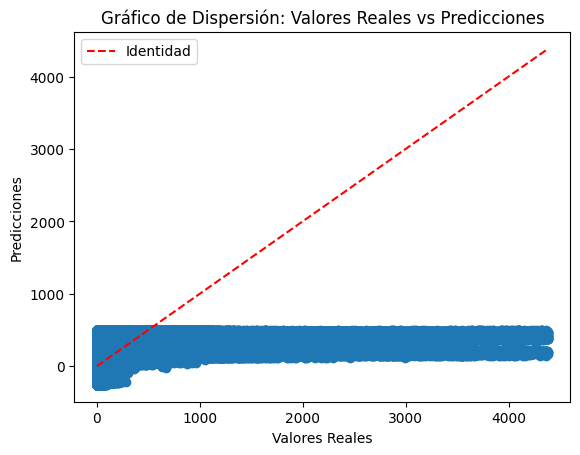

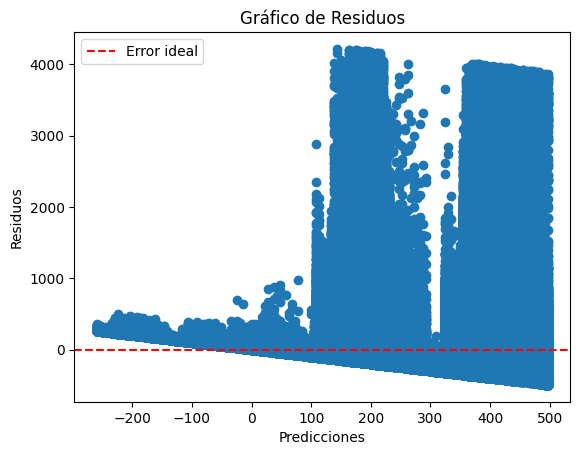

In [9]:
x_train, y_train, x_test, y_test = get_test_train_data('hora', 
                     'es_pesado', 
                     'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3',
                     dataset=dataset)

# Instanciar el modelo
linear_model = LinearRegression()

# Entrenar el modelo
linear_model.fit(x_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = linear_model.predict(x_test)

graph_predictions(y_test, y_pred)

Como el error total fue demasiado alto, se decidió probar con distintas combinaciones de las variables predictoras. El modelo que logró el mejor resultado fue el que utilizó todas las variables posibles.

### Regresión lineal múltiple con dataset completo

             hora  id_peaje_0  id_peaje_1  id_peaje_2  hacia_provincia  \
0       -1.834284   -0.895643   -0.988214    1.116382        -1.044956   
1        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
2        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
3        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
4        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
...           ...         ...         ...         ...              ...   
4473486 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473487 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473488 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473489 -0.616072   -0.895643    1.011927    1.116382        -1.044956   
4473490  1.668076    1.116517   -0.988214    1.116382         0.956978   

         es_pesado  tipo_cobro_0  tipo_cobro_1  tipo_cobro_2  tipo_cobro_3  \
0        -0.803574     -0.024406 

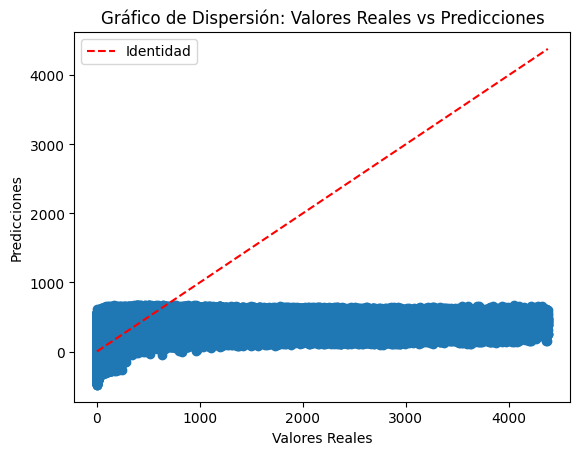

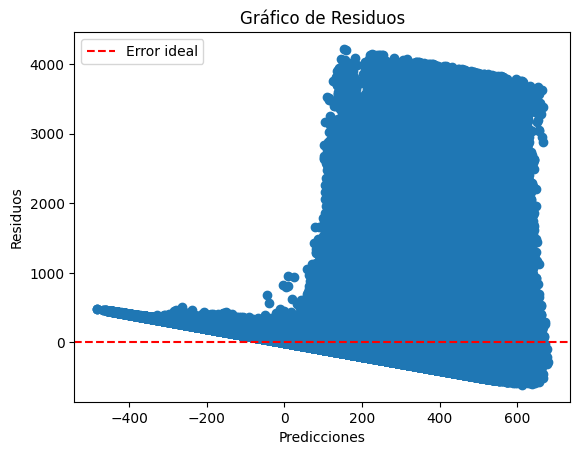

In [10]:
x_train, y_train, x_test, y_test = get_test_train_data("all", dataset=dataset)


# Instanciar el modelo
linear_model = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)

# Entrenar el modelo
linear_model.fit(x_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = linear_model.predict(x_test)

graph_predictions(y_test, y_pred)

## Árbol de decisión

Se hizo la prueba con árboles de distintas profundidades para encontrar el que mejor se ajustara a los datos.

In [11]:
depths = [5, 10, 15, 20, 25, 30]
scores = []
x_train, y_train, x_test, y_test = get_test_train_data("all", dataset=dataset)

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(x_train, y_train)
    score = model.score(x_test, y_test)
    scores.append(score)
    print(f"Max depth: {depth}, R² score: {score:.3f}")



             hora  id_peaje_0  id_peaje_1  id_peaje_2  hacia_provincia  \
0       -1.834284   -0.895643   -0.988214    1.116382        -1.044956   
1        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
2        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
3        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
4        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
...           ...         ...         ...         ...              ...   
4473486 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473487 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473488 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473489 -0.616072   -0.895643    1.011927    1.116382        -1.044956   
4473490  1.668076    1.116517   -0.988214    1.116382         0.956978   

         es_pesado  tipo_cobro_0  tipo_cobro_1  tipo_cobro_2  tipo_cobro_3  \
0        -0.803574     -0.024406 

El que mejor rendimiento produjo es el de max_depth de 20.

             hora  id_peaje_0  id_peaje_1  id_peaje_2  hacia_provincia  \
0       -1.834284   -0.895643   -0.988214    1.116382        -1.044956   
1        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
2        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
3        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
4        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
...           ...         ...         ...         ...              ...   
4473486 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473487 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473488 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473489 -0.616072   -0.895643    1.011927    1.116382        -1.044956   
4473490  1.668076    1.116517   -0.988214    1.116382         0.956978   

         es_pesado  tipo_cobro_0  tipo_cobro_1  tipo_cobro_2  tipo_cobro_3  \
0        -0.803574     -0.024406 

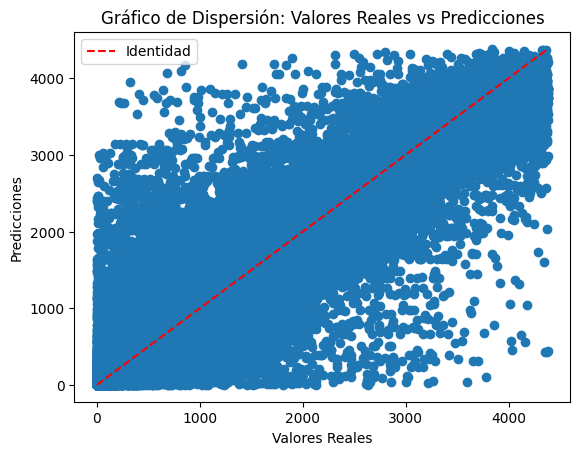

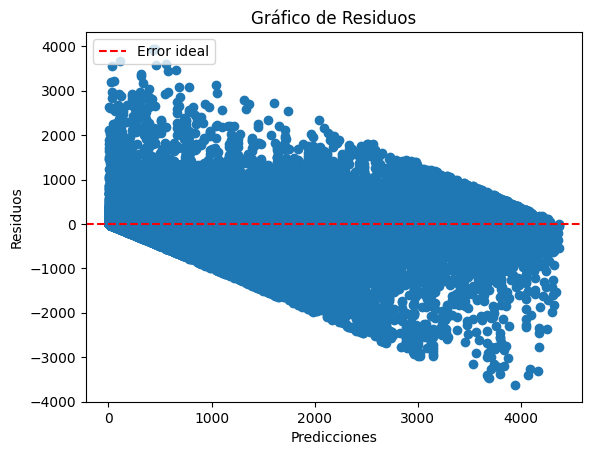

In [12]:
x_train, y_train, x_test, y_test = get_test_train_data("all", dataset=dataset)

# Instanciar y entrenar el modelo
tree_model = DecisionTreeRegressor(criterion="squared_error",
                                 max_depth=20,
                                 min_samples_leaf=1,
                                 min_samples_split=2,
                                 max_features=None,
                                 random_state=42)
tree_model.fit(x_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = tree_model.predict(x_test)

graph_predictions(y_test, y_pred_rf)

## Random forest

Se esperaba que el random forest obtuviera mejores resultados por su capacidad de identificar relaciones no lineales entre las variables.

             hora  id_peaje_0  id_peaje_1  id_peaje_2  hacia_provincia  \
0       -1.834284   -0.895643   -0.988214    1.116382        -1.044956   
1        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
2        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
3        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
4        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
...           ...         ...         ...         ...              ...   
4473486 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473487 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473488 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473489 -0.616072   -0.895643    1.011927    1.116382        -1.044956   
4473490  1.668076    1.116517   -0.988214    1.116382         0.956978   

         es_pesado  tipo_cobro_0  tipo_cobro_1  tipo_cobro_2  tipo_cobro_3  \
0        -0.803574     -0.024406 

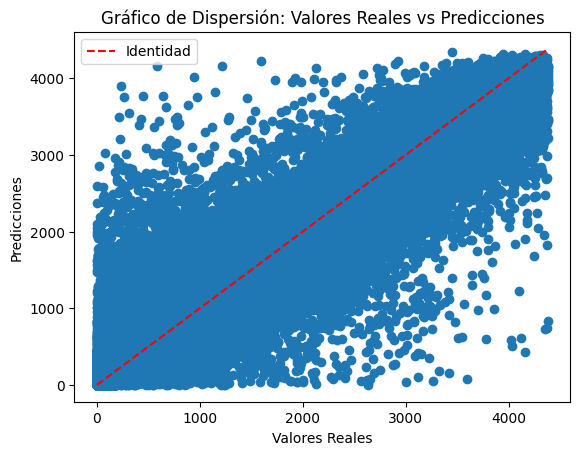

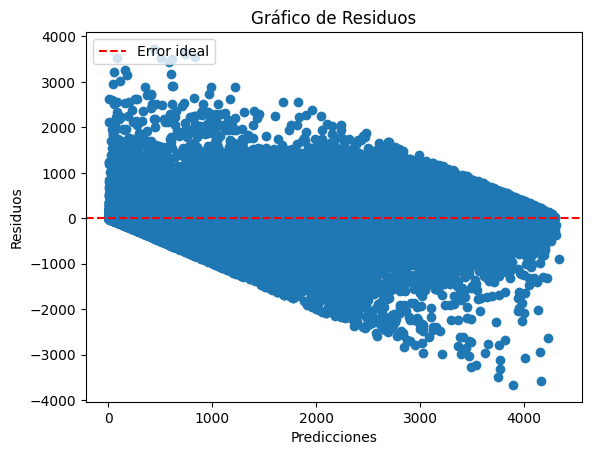

In [13]:
x_train, y_train, x_test, y_test = get_test_train_data("all", dataset=dataset)

# Instanciar y entrenar el modelo
rf_model = RandomForestRegressor(n_estimators=10,
                                 max_depth=None,
                                 random_state=42)
rf_model.fit(x_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = rf_model.predict(x_test)

graph_predictions(y_test, y_pred_rf)

Se probaron diferentes combinaciones de parámetros para limitar la sensibilidad al ruido y generalizar mejor los datos. Sin embargo, esta parametrización fue la que mejor resultado dio.

## Muestra de funcionamiento de los modelos

Para apreciar visualmente cómo reacciona cada uno de los modelos a los distintos valores de entradas, se seleccionarán del dataset de 2024 algunos valores aleatorios y se mostrará la entrada, la predicción del modelo y la salida esperada.

In [14]:
def predict_and_show(model, x, y, dict_errors):
    """
    Realiza predicciones con un modelo y muestra los resultados.
    """

    x_df = pd.DataFrame([x])
    scaler = StandardScaler()
    x_df = pd.DataFrame(scaler.fit_transform(x_df), columns=x_df.columns)

    y_pred = model.predict(x_df)
    abs_err = abs(y - y_pred[0])
    
    print("Entrada:")
    print(x)
    print("\nSalida esperada:", y)
    print("Predicción del modelo:", y_pred[0])
    print("Error absoluto:", abs_err)
    print()

    dict_errors[str(model)].append(abs_err)


### Carga del Dataset 2024
Se hace la carga del dataset limpiado en la entrega dos para hacer las predicciones correspondientes

In [15]:
# Carga la data del 2024

data_2024 = encode_columns(prepare_dataset("clean_data_2024.csv"))

### Predicciones para el año 2024
Se realizan las redicciones respecto a datos extraidos del 2024 y se realiza la predicción con los tres modelos entrenados anteriormente.

In [16]:

# Se obtienen algunas muestras aleatorias del dataset
sampled_data_2024 = data_2024.sample(1000)
dict_errors = {}

for model in [linear_model, tree_model, rf_model]:
    print()
    print("---------------")
    print(model)
    dict_errors.update({str(model): []})

    for i, row in sampled_data_2024.iterrows():
        x = row.drop("pasos")
        y = row["pasos"]
        predict_and_show(model, x, y, dict_errors)

print("Errores absolutos de cada modelo en estas muestras:")
for model, errors in dict_errors.items():
    print(f"\t{model}: {np.mean(errors)}")


---------------
LinearRegression()
Entrada:
hora                 23
id_peaje_0            0
id_peaje_1            1
id_peaje_2            0
hacia_provincia       0
es_pesado             0
tipo_cobro_0          0
tipo_cobro_1          1
tipo_cobro_2          0
tipo_cobro_3          1
nro_dia              15
nro_mes               4
anio               2024
dia_semana            0
Name: 130474, dtype: int64

Salida esperada: 46
Predicción del modelo: 180.75152111559476
Error absoluto: 134.75152111559476

Entrada:
hora                 11
id_peaje_0            0
id_peaje_1            1
id_peaje_2            0
hacia_provincia       0
es_pesado             0
tipo_cobro_0          0
tipo_cobro_1          1
tipo_cobro_2          0
tipo_cobro_3          1
nro_dia               3
nro_mes               1
anio               2024
dia_semana            2
Name: 3465, dtype: int64

Salida esperada: 428
Predicción del modelo: 180.75152111559476
Error absoluto: 247.24847888440524

Entrada:
hora          

# Predicción 2025

In [17]:
# Define the range for dates in 2025
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Define the weekdays in Spanish
dias = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']

# Map dates to corresponding weekdays
dates = [(fecha.strftime('%Y-%m-%d'), dias[fecha.weekday()]) for fecha in date_range]

# Define exhaustive lists for each other column
horas = np.arange(0.0, 24.0, 1.0)    # Decimal hours from 0.0 to 23.0
id_peaje = ['ALB', 'AVE', 'DEC', 'ILL', 'RET', 'SAL', 'SAR']
sentido = ['Centro', 'Provincia']
tipo_vehiculo = ['Liviano', 'Pesado']
tipo_cobro = ['Tag', 'Efectivo', 'Monedero virtual', 'Rec. Deuda', 'Exento', 'Tarjeta Magnetica', 'Infraccion', 'Otro']

# Create all combinations of other columns
combinations = list(product(horas, id_peaje, sentido, tipo_vehiculo, tipo_cobro))

# Expand each date to all combinations of other columns
data = []
for fecha, dia in dates:
    for combo in combinations:
        data.append((fecha, dia, *combo))

# Create DataFrame
columns = ['fecha', 'dia', 'hora', 'id_peaje', 'sentido', 'tipo_vehiculo', 'tipo_cobro']
df = pd.DataFrame(data, columns=columns)

# Display part of the DataFrame to confirm
print(df.head())
print(f"DataFrame size: {df.shape}")

df.to_csv("2025test1.csv", index=False)

        fecha        dia  hora id_peaje sentido tipo_vehiculo  \
0  2025-01-01  Miercoles   0.0      ALB  Centro       Liviano   
1  2025-01-01  Miercoles   0.0      ALB  Centro       Liviano   
2  2025-01-01  Miercoles   0.0      ALB  Centro       Liviano   
3  2025-01-01  Miercoles   0.0      ALB  Centro       Liviano   
4  2025-01-01  Miercoles   0.0      ALB  Centro       Liviano   

         tipo_cobro  
0               Tag  
1          Efectivo  
2  Monedero virtual  
3        Rec. Deuda  
4            Exento  
DataFrame size: (1962240, 7)


In [18]:
dataset2025_original = prepare_dataset("2025test1.csv")
dataset2025 = encode_columns(dataset2025_original)

In [ ]:
scaler = StandardScaler()
test2025_scaled = pd.DataFrame(scaler.fit_transform(dataset2025), columns=dataset2025.columns)
y_pred = rf_model.predict(dataset2025)

In [ ]:
dataset2025['pasos'] = y_pred
dataset2025

,hora,id_peaje_0,id_peaje_1,id_peaje_2,hacia_provincia,es_pesado,tipo_cobro_0,tipo_cobro_1,tipo_cobro_2,tipo_cobro_3,nro_dia,nro_mes,anio,dia_semana,pasos
0,0.0,0,0,1,0,0,0,0,0,1,1,1,2025,2,37.0
1,0.0,0,0,1,0,0,0,0,1,0,1,1,2025,2,44.6
2,0.0,0,0,1,0,0,0,0,1,1,1,1,2025,2,37.0
3,0.0,0,0,1,0,0,0,1,0,0,1,1,2025,2,44.6
4,0.0,0,0,1,0,0,0,1,0,1,1,1,2025,2,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962235,23.0,1,1,1,1,1,0,1,0,0,31,12,2025,2,2.8
1962236,23.0,1,1,1,1,1,0,1,0,1,31,12,2025,2,1.1
1962237,23.0,1,1,1,1,1,0,1,1,0,31,12,2025,2,2.8
1962238,23.0,1,1,1,1,1,0,1,1,1,31,12,2025,2,1.1
